In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Lectura de datos

In [4]:
# DIR = "/content/drive/MyDrive/Data Mining Properati/"
#df_train = pd.read_csv(DIR + "properati_entrenamiento.zip", index_col="id")  
#df_test = pd.read_csv(DIR + "properati_a_predecir.zip", index_col="id")  
df_test = pd.read_feather('bases/properati_a_predecir.ftr').set_index('id')
df_train = pd.read_feather('bases/properati_entrenamiento.ftr').set_index('id')

# df_test = pd.read_feather(DIR+'properati_a_predecir.ftr').set_index('id')
# df_train = pd.read_feather(DIR+'properati_entrenamiento.ftr').set_index('id')
# df_test.head()

# Entendimiento (magia parte 1 -- AID)

In [5]:
df_test.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,-58.442399,-34.573623,Argentina,Capital Federal,Colegiales,None,...,2.0,NaN,NaN,NaN,USD,None,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta
192912,Propiedad,2020-06-05,2020-06-08,2020-06-05,-58.430493,-34.606620,Argentina,Capital Federal,Almagro,None,...,2.0,77.0,67.0,NaN,USD,None,Departamento de 3 ambientes en Venta en Almagro,Excelente departamento de tres ambientes ampli...,Departamento,Venta
238224,Propiedad,2020-07-01,9999-12-31,2020-07-01,-58.491760,-34.574123,Argentina,Capital Federal,Villa Urquiza,None,...,1.0,60.0,55.0,NaN,USD,None,Andonaegui 2600 4° - - Departamento en Venta,Excelente 3 ambientes al frente con balcón. Vi...,Departamento,Venta
257134,Propiedad,2019-08-17,9999-12-31,2019-08-17,-58.420737,-34.631770,Argentina,Capital Federal,Boedo,None,...,1.0,74.0,47.0,NaN,USD,None,PH Venta Boedo 2 amb Patio,Corredor Responsable: MARCELO TRUJILLO - CPI ...,PH,Venta
521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,-58.429983,-34.607225,Argentina,Capital Federal,Almagro,None,...,1.0,66.0,64.0,NaN,USD,None,Venta 3 Ambientes - Almagro - Balcón - Ameniti...,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento,Venta


In [6]:
prueba = df_test.copy()

prueba.start_date = pd.to_datetime(prueba.start_date)

prueba.loc[prueba.end_date=='9999-12-31','end_date'] = np.nan

prueba.end_date = pd.to_datetime(prueba.end_date)
prueba.created_on = pd.to_datetime(prueba.created_on)

In [7]:
train = df_train.copy()

train.start_date = pd.to_datetime(train.start_date)

train.loc[train.end_date=='9999-12-31','end_date'] = np.nan

train.end_date = pd.to_datetime(train.end_date)
train.created_on = pd.to_datetime(train.created_on)

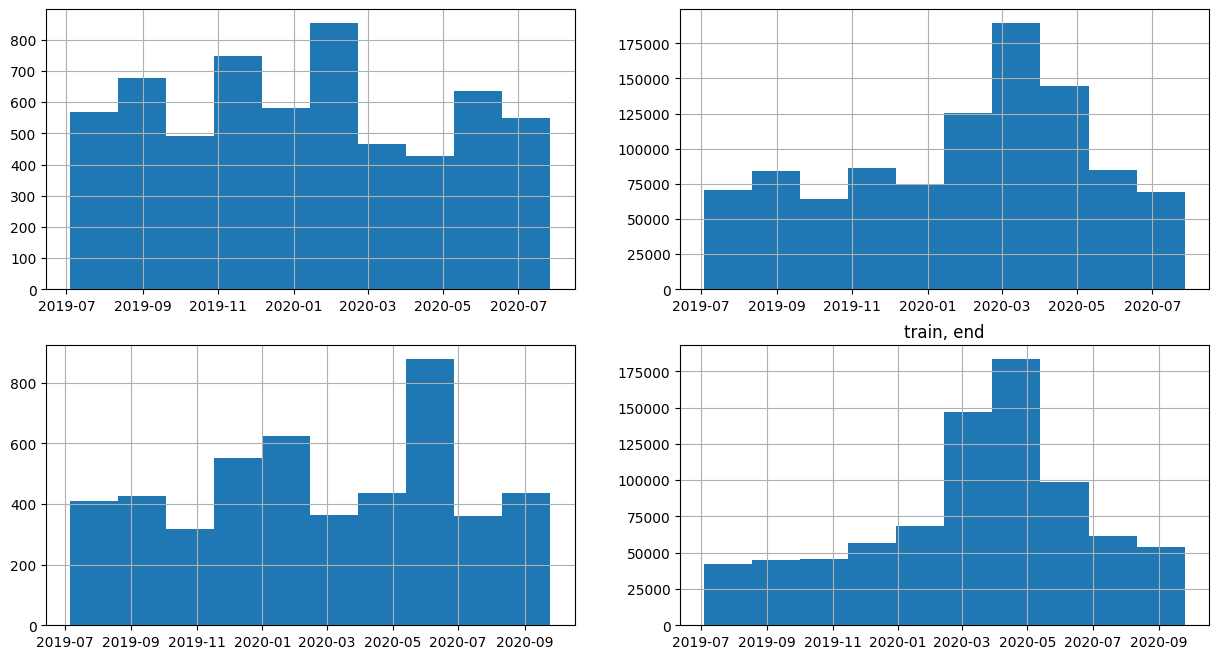

In [8]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(15,8))
prueba.start_date.hist(ax=ax[0,0])
ax[0,0] = plt.title('test, start')
prueba.end_date.hist(ax=ax[1,0])
ax[1,0] = plt.title('test, end')
train.start_date.hist(ax=ax[0,1])
ax[0,1] = plt.title('train, start')
train.end_date.hist(ax=ax[1,1])
ax[1,1] = plt.title('train, end')


# Limpieza y transformación de datos (magia parte 2 -- MD)

In [9]:
raro = df_test['surface_total']<df_test['surface_covered']

df_test.loc[raro,'surface_total'], df_test.loc[raro,'surface_covered'] = df_test.loc[raro,'surface_covered'], df_test.loc[raro,'surface_total']

In [10]:
raro = df_train['surface_total']<df_train['surface_covered']

df_train.loc[raro,'surface_total'], df_train.loc[raro,'surface_covered'] = df_train.loc[raro,'surface_covered'], df_train.loc[raro,'surface_total']

In [11]:
en_amba_train = (df_train.lat>-60)&(df_train['lon']>-35.5)&(df_train['lon']<-34)& (df_train.lat<-56.5) & (df_train.l1=='Argentina')
en_amba_test  =  (df_test.lat>-60)&(df_test['lon']>-35.5)&(df_test['lon']<-34)& (df_test.lat<-56.5) & (df_test.l1=='Argentina')

# en_ballester = ((df_train.title.str.upper().str.contains('BALLESTER')) | (df_train.description.str.upper().str.contains('BALLESTER'))&
#                 en_amba_train)
# ballester = df_train[en_ballester]

no_lugares = ['Bs.As. G.B.A. Zona Sur','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Oeste']

#Filtramos los que se encuentran dentro del rango de AMBA y que no son del conurbano
df_train = df_train[en_amba_train & (~df_train.l2.isin(no_lugares))]

#Pulimos la zona circundante a la plata para que coincida con el test
df_train = df_train[(df_train.l2=='Capital Federal')|((df_train.l2=='Buenos Aires Interior')&(df_train.lat>-58.15)&(df_train.lon<-34.7)&(df_train.lon>-35.1))]

# df_train = pd.concat((df_train,ballester),axis=0)

df_train = df_train[(df_train.price_period=='Mensual')|(df_train.price_period.isnull())] #TODO ver si sacarlo 

df_train.loc[df_train.l2=='Buenos Aires Interior','l2'] = 'Bs.As. G.B.A. Zona Sur'

df_train = df_train[df_train.operation_type=='Venta']

df_test.loc[df_test.title.str.contains('en Las Cañitas'),'l3'] = "Las Cañitas"
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas')) & (df_test.lat<-58.4),'lat'] = np.nan

df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.47),'l3'] = 'Villa Urquiza'
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.44),['lat','lon']] = np.nan

df_train.shape

(152720, 24)

In [12]:
df_test.loc[~en_amba_test,['lat','lon']] = np.nan

In [13]:
cols_a_imputar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','lat','lon']
# crear nuevas columnas para indicar los valores imputados
for column in cols_a_imputar:
    is_imputed_train = np.where(df_train[column].isnull(), True, False)
    is_imputed_test = np.where(df_test[column].isnull(), True, False)
    df_train[column + '_imputed'] = is_imputed_train
    df_test[column + '_imputed'] = is_imputed_test

In [14]:
#df_train['train_test'] = 'train'
#df_test['train_test'] = 'test'

#df = pd.concat((df_train,df_test),axis=0)

#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(dos|2) baños'))   ,'bathrooms'] = 2
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(tres|3) baños'))  ,'bathrooms'] = 3
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cuatro|4) baños')),'bathrooms'] = 4
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cinco|5) baños')) ,'bathrooms'] = 5
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(seis|6) baños'))  ,'bathrooms'] = 6
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('baño(\ |\.|\,)'))  ,'bathrooms'] = 1

#df_train = df[df.train_test=='train']
#df_test = df[df.train_test=='test']

#df_train.drop(columns='train_test',inplace=True)
#df_test.drop(columns='train_test',inplace=True)

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [16]:
imp = IterativeImputer(max_iter=10, random_state=42)  # tiene add_indicator

cols_a_imputar = ['rooms','bedrooms','bathrooms', 'surface_total','surface_covered']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

cols_a_imputar = ['lat','lon']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [17]:

df_test.rooms      = df_test.rooms.astype('int')
df_train.rooms     = df_train.rooms.astype('int')
df_test.bedrooms   = df_test.bedrooms.astype('int')
df_train.bedrooms  = df_train.bedrooms.astype('int')
df_test.bathrooms  = df_test.bathrooms.astype('int')
df_train.bathrooms = df_train.bathrooms.astype('int')

## Filtrado

In [18]:
pd.concat((df_train.property_type.value_counts(dropna=False),
           df_test.property_type.value_counts(dropna=False)),axis=1).sort_index()

,property_type,property_type
Casa,6878,NaN
Casa de campo,7,NaN
Cochera,2894,NaN
Departamento,97209,5426.0
Depósito,917,NaN
Local comercial,5940,NaN
Lote,8230,NaN
Oficina,4983,NaN
Otro,15649,NaN
PH,10013,574.0


In [19]:
df_train = df_train[df_train.property_type.isin(['PH','Departamento'])]

In [20]:
pd.concat((df_train.bathrooms.value_counts(dropna=False),
           df_test.bathrooms.value_counts(dropna=False)),axis=1)

,bathrooms,bathrooms
1,72464,4605.0
2,23804,1227.0
3,6969,144.0
4,2254,20.0
0,915,NaN
5,633,1.0
6,113,3.0
7,28,NaN
8,12,NaN
11,4,NaN


In [21]:
df_train = df_train[(df_train['bathrooms']<=6) | (df_train['bathrooms'].isnull())]
df_train.shape

(107152, 31)

In [22]:
pd.concat((df_train.currency.value_counts(dropna=False),
           df_test.currency.value_counts(dropna=False)),axis=1)

,currency,currency
USD,102422,6000.0
None,3910,NaN
ARS,820,NaN


In [23]:
df_train = df_train[df_train.currency=='USD'] #saco tambien los nulos porque no tienen precio
df_train.shape

(102422, 31)

In [24]:
pd.concat((df_train.rooms.value_counts(dropna=False),
           df_test.rooms.value_counts(dropna=False)),axis=1).sort_index()

,rooms,rooms
1,20682,NaN
2,30582,2984.0
3,26593,3016.0
4,17756,NaN
5,4668,NaN
6,1264,NaN
7,481,NaN
8,258,NaN
9,46,NaN
10,45,NaN


In [25]:
# df_train = df_train[(df_train.rooms<7) |(df_train.rooms.isnull())]
df_train.shape

(102422, 31)

In [26]:
pd.concat((df_train.bedrooms.value_counts(dropna=False),
           df_test.bedrooms.value_counts(dropna=False)),axis=1).sort_index()

,bedrooms,bedrooms
-1,2,NaN
0,15245,3.0
1,38133,3312.0
2,27821,2660.0
3,16558,23.0
4,3729,1.0
5,507,1.0
6,227,NaN
7,144,NaN
8,22,NaN


In [27]:
# df_train = df_train[(df_train.bedrooms<6) |(df_train.bedrooms.isnull())]
df_train.shape

(102422, 31)

<AxesSubplot: xlabel='surface_covered'>

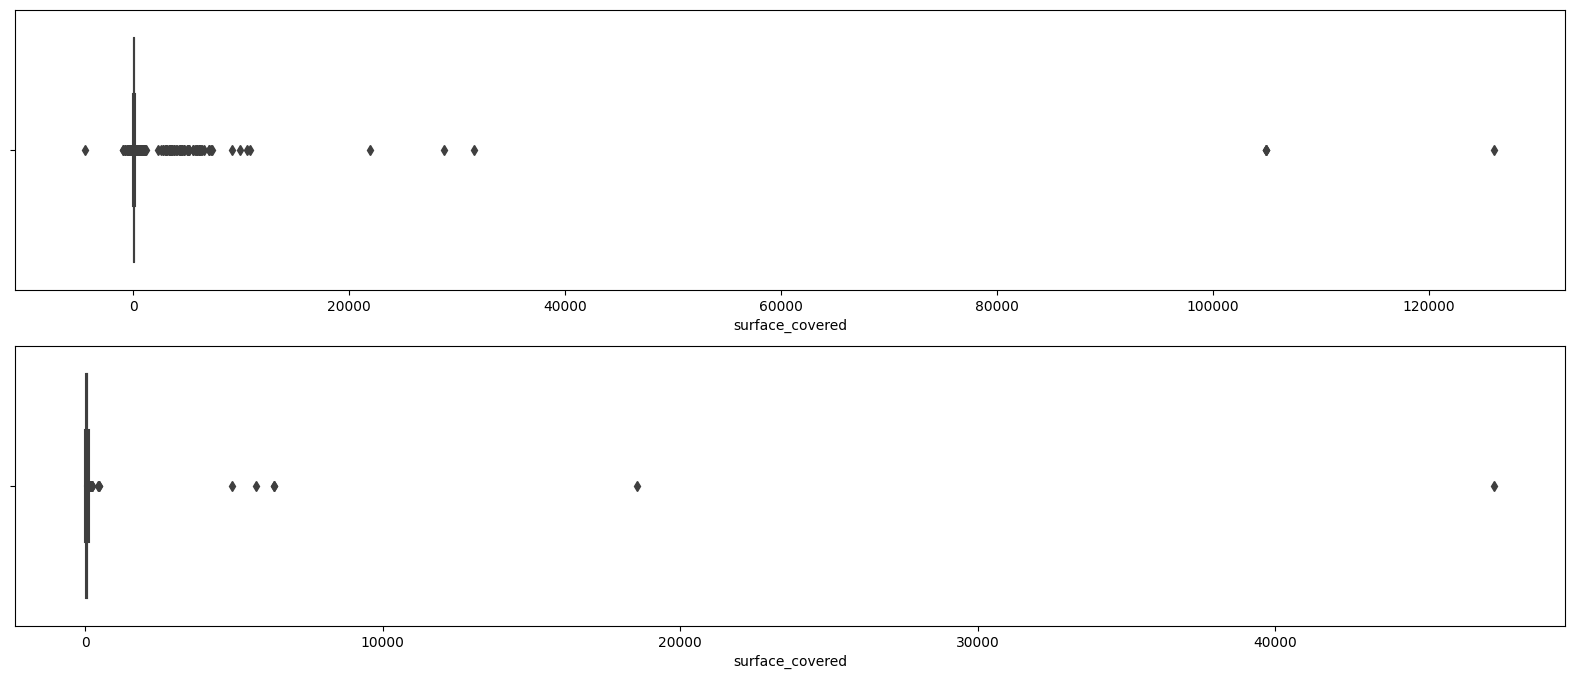

In [28]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_covered',ax=ax[0])
sns.boxplot(data=df_test,x='surface_covered',ax=ax[1])

In [29]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,102422.0,87.192914,720.887917,-4432.263411,41.0,61.0,98.0,126062.0
surface_total,102422.0,138.086412,1024.722444,-149575.086421,43.0,69.0,130.0,126062.0


In [30]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [31]:
df_train = df_train[((df_train['surface_covered']>=20)&(df_train['surface_covered']<50000))|(df_train['surface_covered'].isnull())]
df_train.shape

(100591, 31)

<AxesSubplot: xlabel='surface_total'>

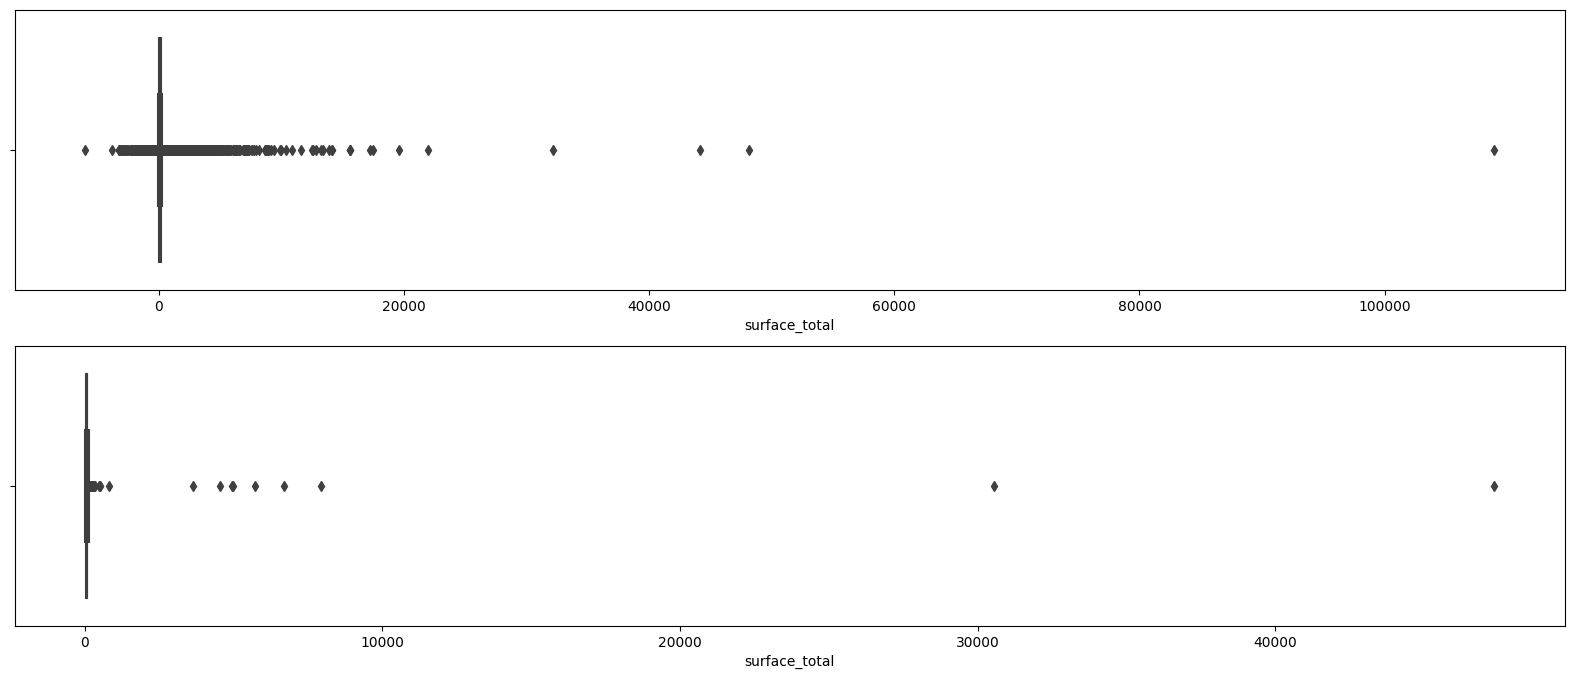

In [32]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_total',ax=ax[0])
sns.boxplot(data=df_test,x='surface_total',ax=ax[1])

In [33]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,100591.0,85.257393,207.768667,20.000000,41.044627,62.0,100.0,31550.0
surface_total,100591.0,146.328567,580.711035,-6008.880032,43.000000,70.0,130.0,108960.0


In [34]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [35]:
df_train = df_train[((df_train['surface_total']>=10)&(df_train['surface_total']<50000))|(df_train['surface_total'].isnull())]
df_train.shape

(95914, 31)

In [36]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,95914.0,82.577618,212.001841,20.0,41.0,60.0,91.0,31550.0
surface_total,95914.0,169.079044,457.650534,12.0,46.0,73.0,138.0,48170.0


In [37]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [38]:
df_train.price.value_counts().sort_index()

5000.0        1
9500.0        1
10000.0       5
10500.0       2
11111.0       1
             ..
9477000.0     3
11111111.0    1
12345678.0    1
15011160.0    1
32434232.0    1
Name: price, Length: 6371, dtype: int64

## Imputación de nulos

## Armado de variables

In [39]:
df = pd.concat((df_train,df_test),axis=0)

df['bathrooms_rooms'] = df['bathrooms']/df['rooms']
df['bedrooms_rooms'] = df['bedrooms']/df['rooms']
df['covered'] = df['surface_covered']/df['surface_total']

df['start_year']  = pd.to_datetime(df['start_date']).dt.year
df['start_month'] = pd.to_datetime(df['start_date']).dt.month
df['start_day'] = pd.to_datetime(df['start_date']).dt.month

df['tiene_esp_abierto'] = 0
df.loc[(df['surface_total']-df['surface_covered'])!=0,'tiene_esp_abierto'] = 1

df['description'] = df["description"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')
#df['title'] = df["title"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')

for c in ["barrio privado", "corredor",'suite','monoambiente','amueblado',
          'ascensor','parrilla','patio','balcon','jardin','linea (a|b|b|c|d|e|h)',
          'obelisco','catedral','metrobus','barrancas','barrio chino','river',
          'universidad','facultad','subte','tren','estacion','museo','parque','jacuzzi',
          '(j|y)acu(z|zz)i','sho(pp|p)ing','country','terminal','avenida','av.','av',
          'expensa','expensas','a(mm|m)enities','inmobiliaria','dueñ(o|a) direct(o|a)',
          'balcon','pileta|piscina','escuela|colegio','centro','microcentro','lago','libertador','baulera']:
    df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
    #df[f"title_{c}"] = df["title"].str.contains(c,regex=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13236\2780377968.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13236\2780377968.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13236\2780377968.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13236\2780377968.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.ex

In [40]:
df.covered.value_counts(dropna=False).sort_index()

0.000851     1
0.004233     1
0.004679     1
0.005105     1
0.007350     1
            ..
19.352209    2
20.143609    1
21.003826    2
24.100608    1
26.738608    1
Name: covered, Length: 5677, dtype: int64

In [41]:
# from sklearn.preprocessing import LabelEncoder

# labelencoder = LabelEncoder()

# df['l3'] = labelencoder.fit_transform(df['l3'])

In [42]:
df_train = df[~df.price.isnull()]
df_test = df[df.price.isnull()]

## Selección de atributos

In [43]:
cols = ['l1','l5','l6','ad_type','currency','operation_type']
df_train.drop(cols,inplace=True,axis=1)
df_test.drop(cols,inplace=True,axis=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13236\2438721469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(cols,inplace=True,axis=1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13236\2438721469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(cols,inplace=True,axis=1)


## Dummies

In [44]:
cols_dummies = ['l2','l3','l4','property_type']
train_dummies = pd.get_dummies(df_train[cols_dummies],dummy_na=True)
df_train = pd.concat((df_train,train_dummies),axis=1)

test_dummies = pd.get_dummies(df_test[cols_dummies],dummy_na=True)
df_test = pd.concat((df_test,test_dummies),axis=1)

In [45]:
cols = pd.concat((df_train,df_test),axis=0,join='inner').columns

df_train = df_train[cols]
df_test = df_test[cols]

## Borrado por varianza

In [46]:
from sklearn.feature_selection import VarianceThreshold

In [47]:
# F = df_train[~df_train.price.isnull()]
# X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
# y = F['price']

# print(X.shape)
# fs = VarianceThreshold(threshold=0.005)
# X_new = fs.fit_transform(X) # threshold = limite superior de la varianza
# print(X_new.shape)

# cols = list(X.columns[fs.get_support()])
# cols.append('price')

# df_train = df_train[cols]
# df_test = df_test[cols]

In [48]:
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))&(df_train.lat<-58.42),'lat'] = -58.361

In [49]:
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))&(df_test.lat<-58.4),'lat'] = -58.361

<AxesSubplot: xlabel='lat', ylabel='lon'>

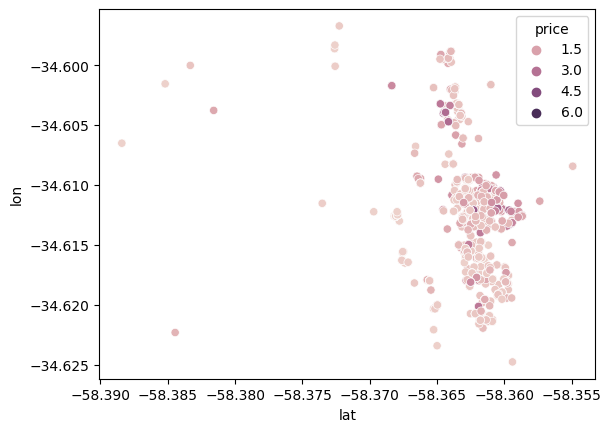

In [50]:
sns.scatterplot(data=df_train[(df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')],x='lat',y='lon',hue='price')

In [51]:
# df_test['lat'], df_test['lon'] = df_test['lon'], df_test['lat']
# df_train['lat'], df_train['lon'] = df_train['lon'], df_train['lat']
# from shapely.geometry import Point
# df_test['punto'] = df_test.apply(lambda row: Point(row['lat'], row['lon']), axis=1)
# df_train['punto'] = df_train.apply(lambda row: Point(row['lat'], row['lon']), axis=1)

## División de base

In [52]:
df_test_la_plata = df_test[(df_test.lat>-58.2)&(df_test.lon<-34.8)]
df_train_la_plata = df_train[(df_train.lat>-58.2)&(df_train.lon<-34)]

df_test_caba = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&~((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]
df_train_caba = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&~((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]

In [53]:
df_test_madero = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]

df_train_madero = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]

corredor_norte = ['Retiro','Recoleta','Barrio Norte']#,'Nuñez','Distrito Audiovisual','Palermo','Belgrano','Coghlan','Las Cañitas',]

df_train_corredor_norte = df_train_caba[df_train_caba.l3.isin(corredor_norte)]
df_test_corredor_norte = df_test_caba[df_test_caba.l3.isin(corredor_norte)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(corredor_norte)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(corredor_norte)]

corredor_sur = ['Villa Riachuelo','Villa Lugano','Villa Soldati','Pompeya','Boca','Constitución']#'Barracas','Parque Patricios']

df_train_corredor_sur = df_train_caba[df_train_caba.l3.isin(corredor_sur)]
df_test_corredor_sur = df_test_caba[df_test_caba.l3.isin(corredor_sur)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(corredor_sur)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(corredor_sur)]

caballito = ['Almagro','Caballito','Parque Centenario','Villa Crespo']

df_train_caballito = df_train_caba[df_train_caba.l3.isin(caballito)]
df_test_caballito= df_test_caba[df_test_caba.l3.isin(caballito)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(caballito)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(caballito)]

palermo = ['Palermo','Distrito Audiovisual','Las Cañitas']
df_train_palermo = df_train_caba[df_train_caba.l3.isin(palermo)]
df_test_palermo= df_test_caba[df_test_caba.l3.isin(palermo)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(palermo)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(palermo)]

belgrano = ['Belgrano','Nuñez','Coghlan']
df_train_belgrano = df_train_caba[df_train_caba.l3.isin(belgrano)]
df_test_belgrano= df_test_caba[df_test_caba.l3.isin(belgrano)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(belgrano)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(belgrano)]


noroeste = ['Saavedra','Villa Ortuzar','Villa Urquiza']#,'Coghlan']

df_train_noroeste = df_train_caba[df_train_caba.l3.isin(noroeste)]
df_test_noroeste= df_test_caba[df_test_caba.l3.isin(noroeste)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(noroeste)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(noroeste)]

centro = ['San Nicolás','Monserrat','Tribunales','Centro / Microcentro']

df_train_centro = df_train_caba[df_train_caba.l3.isin(centro)]
df_test_centro= df_test_caba[df_test_caba.l3.isin(centro)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(centro)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(centro)]

df_train_devoto = df_train_caba[df_train_caba.l3=='Villa Devoto']
df_test_devoto = df_test_caba[df_test_caba.l3=='Villa Devoto']

df_train_caba = df_train_caba[df_train_caba.l3!='Villa Devoto']
df_test_caba= df_test_caba[df_test_caba.l3!='Villa Devoto']

df_train_barracas = df_train_caba[df_train_caba.l3=='Barracas']
df_test_barracas = df_test_caba[df_test_caba.l3=='Barracas']

df_train_caba = df_train_caba[df_train_caba.l3!='Barracas']
df_test_caba= df_test_caba[df_test_caba.l3!='Barracas']

In [54]:
df_train_palermo.price.max()

32434232.0

In [55]:
# df_train_palermo['price_cut'] = pd.cut(df_train_palermo['price'],bins=10)
# df_train_palermo.price_cut.value_counts(dropna=False).sort_index()

In [56]:
df_train_palermo.loc[df_train_palermo.price==32434232,'price'] = 32434232/10

In [57]:
# df_train_palermo['price_cut'] = pd.cut(df_train_palermo['price'],bins=5)
# sns.scatterplot(data=df_train_palermo[df_train_palermo.price_cut!=df_train_palermo.price_cut.min()],x='lat',y='lon',hue='l3')

In [58]:
# df_train_belgrano['price_cut'] = pd.cut(df_train_belgrano['price'],bins=5)
# sns.scatterplot(data=df_train_belgrano[df_train_belgrano.price_cut!=df_train_belgrano.price_cut.min()],x='lat',y='lon',hue='price_cut')

<AxesSubplot: xlabel='price', ylabel='l3'>

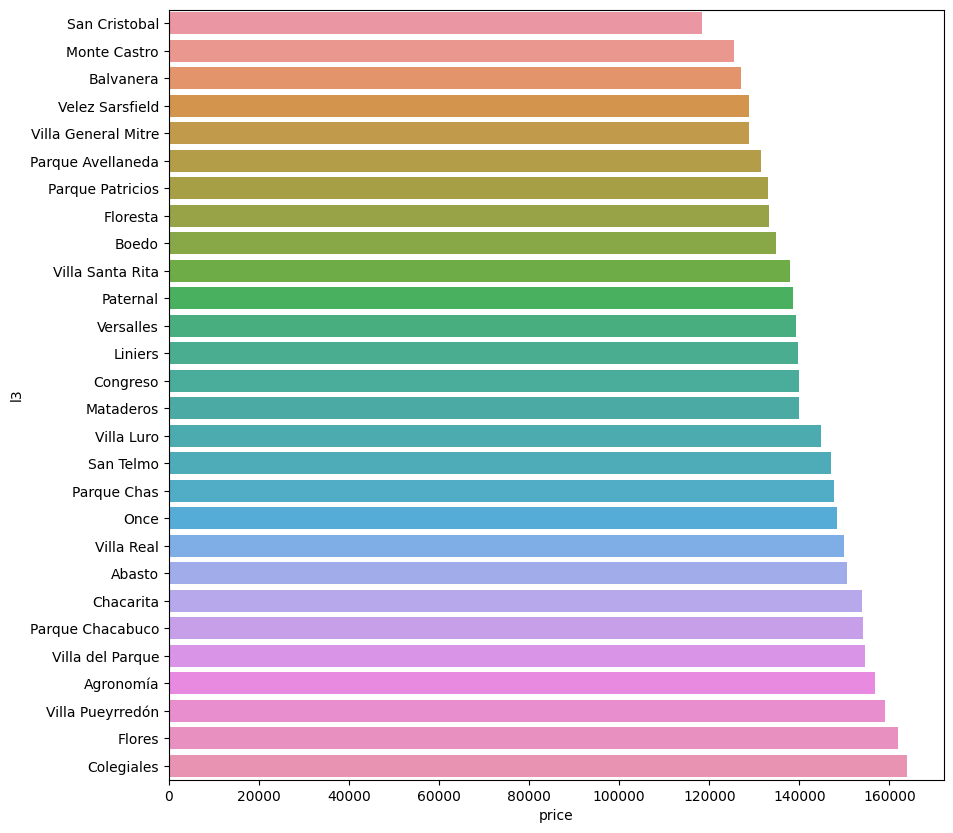

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=df_train_caba.groupby('l3').agg({'price':'mean'}).reset_index().sort_values('price'),y='l3',x='price')

In [60]:
def filtrado_columnas(df_test,df_train):
    F = df_train[~df_train.price.isnull()]
    X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
    y = F['price']

    clf = sk.ensemble.RandomForestRegressor(n_estimators=50, n_jobs=-1,random_state=42)
    clf.fit(X, y)

    importancias = pd.DataFrame({'atributo': clf.feature_names_in_, 'importancia': clf.feature_importances_})
    cols = list(importancias[importancias['importancia']>0.0001].sort_values('importancia',ascending=False).reset_index(drop=True).atributo)

    cols.append('price')

    display(importancias.sort_values('importancia').tail(10))

    df_train = df_train[cols]
    df_test = df_test[cols]

    print(df_train.shape)
    return df_test, df_train

In [61]:
import spacy
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# spacy.cli.download("es_core_news_sm")
from sklearn.feature_extraction.text import CountVectorizer
nlp = spacy.load("es_core_news_sm")
stopwords = nlp.Defaults.stop_words

In [62]:
def tokenizacion(df_test,df_train,columna):
    df = pd.concat((df_test,df_train),axis=0)
    
    df[columna] = df[columna].fillna('NA')

    nlp = spacy.load("es_core_news_sm")
    stopwords = nlp.Defaults.stop_words

    df[columna+'_tok'] = df[columna].apply(lambda texto: [token.text for token in nlp(texto)])
    df[columna+'_tok'] = df[columna+'_tok'].apply(lambda texto: [token for token in texto if token not in stopwords])
    df[columna] = df[columna+'_tok'].str.join(' ')

    vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000)
    vectorized_data = vectorizer.fit_transform(df[columna])

    count_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat((df,count_df),axis=1)

    df_train = df[~df.price.isnull()]
    df_test = df[df.price.isnull()]

    return df_test, df_train

In [63]:
from joblib import Parallel, delayed

def tokenize_text(text):
    nlp = spacy.load("es_core_news_sm")
    stopwords = nlp.Defaults.stop_words
    doc = nlp(text)
    tokens = [token.text for token in doc if token.text not in stopwords]
    return ' '.join(tokens)

def tokenizacion(df_test, df_train, columna):
    df = pd.concat((df_test, df_train), axis=0)

    df[columna] = df[columna].fillna('NA')

    # Tokenización en paralelo
    df[columna + '_tok'] = Parallel(n_jobs=-1)(delayed(tokenize_text)(text) for text in df[columna])

    vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000)
    vectorized_data = vectorizer.fit_transform(df[columna + '_tok'])

    count_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat((df, count_df), axis=1)

    df_train = df[~df.price.isnull()]
    df_test = df[df.price.isnull()]

    return df_test, df_train

In [64]:
df_train_madero = pd.concat((df_train_madero,df_train_caba[(df_train_caba.title.fillna('NA').str.contains(' PUERTO MADERO'))]),axis=0)
df_train_caba = df_train_caba[~(df_train_caba.title.fillna('NA').str.contains(' PUERTO MADERO'))]

In [65]:
df_train_barracas = df_train_barracas[~df_train_barracas.title.str.contains('600000')]

df_train_belgrano = pd.concat((df_train_belgrano,df_train_barracas[df_train_barracas.title.str.contains('Barrancas')]),axis=0)

df_train_barracas = df_train_barracas[~df_train_barracas.title.str.contains('Barrancas')]

df_train_devoto = df_train_devoto[df_train_devoto.price<2215000]

df_train_noroeste = df_train_noroeste[df_train_noroeste.price!=df_train_noroeste.price.max()]

In [66]:
pd.cut(df_train_caba.price,bins=10).value_counts()

(5364.939, 423006.1]      23626
(423006.1, 836512.2]        282
(836512.2, 1250018.3]        16
(1250018.3, 1663524.4]        2
(3731054.9, 4144561.0]        2
(1663524.4, 2077030.5]        1
(2077030.5, 2490536.6]        1
(2904042.7, 3317548.8]        1
(2490536.6, 2904042.7]        0
(3317548.8, 3731054.9]        0
Name: price, dtype: int64

In [67]:
df_train_caba[df_train_caba.price>1250018.3].sort_values('price').iloc[:,6:17].title.unique()

array(['Casa - San Telmo', 'Pareja 3900 - Devoto - Capital Federal',
       'VENTA PH RECICLADO, TERRAZA,PILETA SAN TELMO',
       'Departamento - Chacarita',
       'Departamento en Venta en San cristobal, Capital federal U$S 3235598',
       'Muy buen PH. Excelente ubicación.  Sin expensas. 242 m2 totales con terraza.',
       'Departamento en Venta en San cristobal, Capital federal U$S 4144561'],
      dtype=object)

In [68]:
df_train_caba[df_train_caba.title.fillna('NA').str.lower().str.contains('puerto madero')].title.unique()

array(['Hermoso loft/atelier con cochera, reciclado, luminoso y silencioso.  A metros de Puerto Madero.',
       'Ambisioso 2 Ambientes en Torre Le Parc Puerto Madero con Cochera y Baulera Super Luminoso'],
      dtype=object)

<AxesSubplot: xlabel='price', ylabel='l3'>

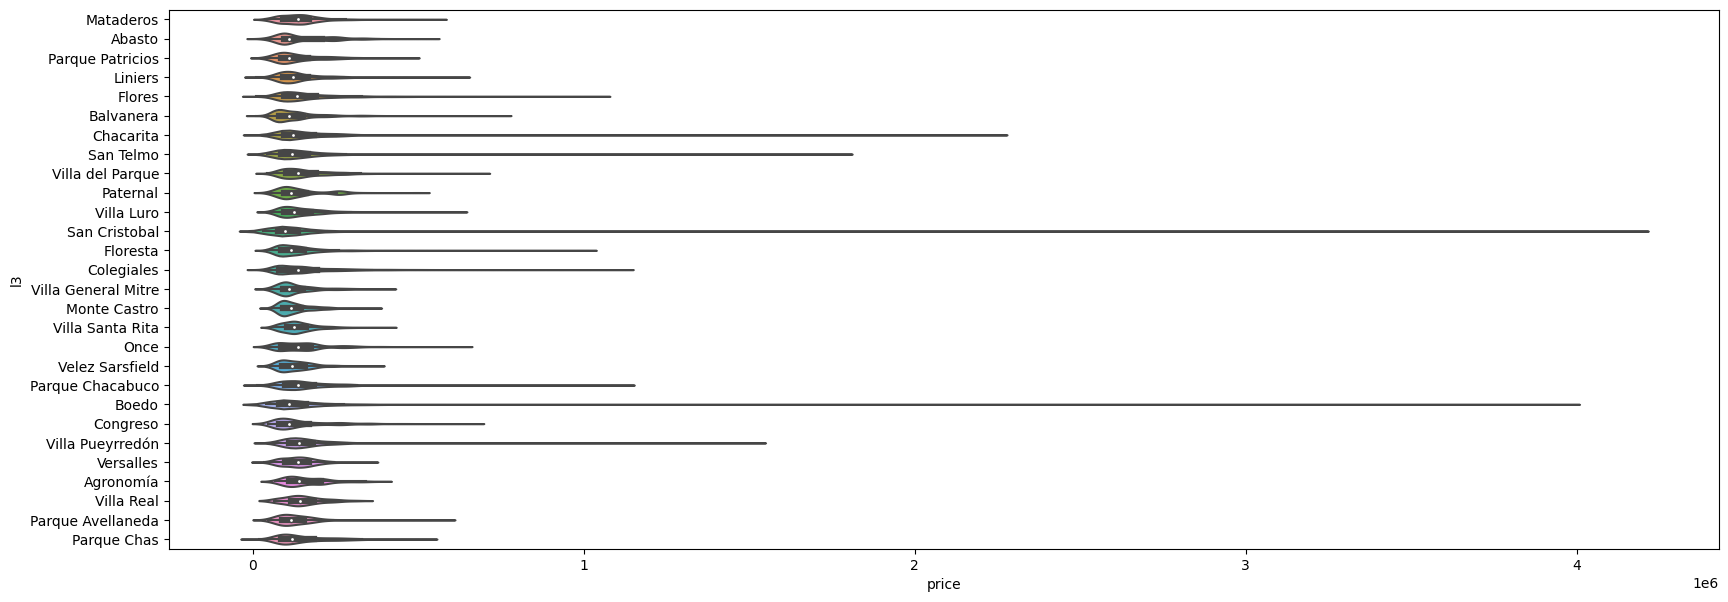

In [69]:
plt.figure(figsize=(20,7))
sns.violinplot(data=df_train_caba,x='price',y='l3')

In [70]:
print(f"La plata tiene {df_train_la_plata.shape[0]} en train y {df_test_la_plata.shape[0]} en test")
print(f"CABA tiene {df_train_caba.shape[0]} en train y {df_test_caba.shape[0]} en test")
print(f"Pto Madero y Catalinas tiene {df_train_madero.shape[0]} en train y {df_test_madero.shape[0]} en test")
print(f"Corr norte tiene {df_train_corredor_norte.shape[0]} en train y {df_test_corredor_norte.shape[0]} en test")
print(f"Corr sur tiene {df_train_corredor_sur.shape[0]} en train y {df_test_corredor_sur.shape[0]} en test")
print(f"Caballito tiene {df_train_caballito.shape[0]} en train y {df_test_caballito.shape[0]} en test")
print(f"Palermo tiene {df_train_palermo.shape[0]} en train y {df_test_palermo.shape[0]} en test")
print(f"Belgrano tiene {df_train_belgrano.shape[0]} en train y {df_test_belgrano.shape[0]} en test")
print(f"Noroeste tiene {df_train_noroeste.shape[0]} en train y {df_test_noroeste.shape[0]} en test")
print(f"Devoto tiene {df_train_devoto.shape[0]} en train y {df_test_devoto.shape[0]} en test")
print(f"Barracas tiene {df_train_barracas.shape[0]} en train y {df_test_barracas.shape[0]} en test")


La plata tiene 60 en train y 264 en test
CABA tiene 23931 en train y 1650 en test
Pto Madero y Catalinas tiene 1466 en train y 100 en test
Corr norte tiene 8622 en train y 428 en test
Corr sur tiene 1703 en train y 111 en test
Caballito tiene 24363 en train y 1373 en test
Palermo tiene 15207 en train y 875 en test
Belgrano tiene 10679 en train y 576 en test
Noroeste tiene 5241 en train y 346 en test
Devoto tiene 1401 en train y 90 en test
Barracas tiene 804 en train y 50 en test


In [71]:
fraccion = .5
print("La Plata")
df_test_la_plata, df_train_la_plata             = tokenizacion(df_test_la_plata,df_train_la_plata,'description')
print("Madero y Catalinas")
df_test_madero, df_train_madero                 = tokenizacion(df_test_madero,df_train_madero,'description')

La Plata
Madero y Catalinas


In [74]:
print("La Plata")
df_test_la_plata, df_train_la_plata = filtrado_columnas(df_test_la_plata,df_train_la_plata)
print("Resto de Caba")
df_test_caba, df_train_caba = filtrado_columnas(df_test_caba,df_train_caba)
print("Madero y Catalinas")
df_test_madero, df_train_madero = filtrado_columnas(df_test_madero,df_train_madero)
print("Corredor Norte")
df_test_corredor_norte, df_train_corredor_norte = filtrado_columnas(df_test_corredor_norte,df_train_corredor_norte)
print("Corredor sur")
df_test_corredor_sur, df_train_corredor_sur = filtrado_columnas(df_test_corredor_sur,df_train_corredor_sur)
print("Caballito")
df_test_caballito, df_train_caballito = filtrado_columnas(df_test_caballito,df_train_caballito)
print("Palermo")
df_test_palermo, df_train_palermo = filtrado_columnas(df_test_palermo,df_train_palermo)
print("Belgrano")
df_test_belgrano, df_train_belgrano = filtrado_columnas(df_test_belgrano,df_train_belgrano)
print("Noroeste")
df_test_noroeste, df_train_noroeste = filtrado_columnas(df_test_noroeste,df_train_noroeste)
print("Centro")
df_test_centro, df_train_centro = filtrado_columnas(df_test_centro,df_train_centro)
print("Devoto")
df_test_devoto, df_train_devoto = filtrado_columnas(df_test_devoto,df_train_devoto)
print("Barracas")
df_test_barracas, df_train_barracas = filtrado_columnas(df_test_barracas,df_train_barracas)

La Plata


,atributo,importancia
1452,linea,0.021287
1115,efectivo,0.024123
1396,inversor,0.024782
206,25,0.026570
2,rooms,0.029217
514,bano dormitorio,0.030781
6,surface_total,0.046882
1688,pasillo,0.051736
1061,dormitorio,0.096107
7,surface_covered,0.277089


(60, 204)
Resto de Caba


,atributo,importancia
58,desc_pileta|piscina,0.019482
59,desc_escuela|colegio,0.024950
18,start_month,0.028393
11,surface_covered_imputed,0.029428
60,desc_centro,0.030333
5,surface_total,0.042479
0,lat,0.062612
1,lon,0.068626
4,bathrooms,0.078077
6,surface_covered,0.395442


(23931, 84)
Madero y Catalinas


,atributo,importancia
1862,semi integrada,0.003513
1,lon,0.003693
0,lat,0.003786
997,excelentes,0.004259
1727,real,0.005148
322,amoblado,0.005555
296,alvear,0.005922
630,cocheras,0.007736
5,surface_total,0.014497
6,surface_covered,0.814981


(1466, 247)
Corredor Norte


,atributo,importancia
14,bathrooms_rooms,0.007156
23,desc_suite,0.007308
15,bedrooms_rooms,0.007337
58,desc_pileta|piscina,0.007400
11,surface_covered_imputed,0.013261
16,covered,0.025048
0,lat,0.038059
1,lon,0.079884
5,surface_total,0.136708
6,surface_covered,0.608170


(8622, 52)
Corredor sur


,atributo,importancia
16,covered,0.014836
2,rooms,0.014934
122,l3_Villa Soldati,0.019624
19,start_day,0.037951
18,start_month,0.046302
0,lat,0.056364
5,surface_total,0.057055
4,bathrooms,0.153586
1,lon,0.197156
6,surface_covered,0.199457


(1703, 61)
Caballito


,atributo,importancia
50,desc_avenida,0.009924
16,covered,0.014239
4,bathrooms,0.014390
8,bedrooms_imputed,0.016096
40,desc_subte,0.018026
60,desc_centro,0.037475
5,surface_total,0.069744
6,surface_covered,0.149027
1,lon,0.173479
0,lat,0.403892


(24363, 54)
Palermo


,atributo,importancia
14,bathrooms_rooms,0.011266
58,desc_pileta|piscina,0.012247
11,surface_covered_imputed,0.015165
23,desc_suite,0.016590
16,covered,0.017122
1,lon,0.032039
5,surface_total,0.049117
55,desc_a(mm|m)enities,0.053292
0,lat,0.061172
6,surface_covered,0.660495


(15207, 56)
Belgrano


,atributo,importancia
4,bathrooms,0.017817
2,rooms,0.018353
16,covered,0.019288
11,surface_covered_imputed,0.029387
5,surface_total,0.040020
58,desc_pileta|piscina,0.043558
55,desc_a(mm|m)enities,0.048549
0,lat,0.060358
1,lon,0.071950
6,surface_covered,0.536034


(10679, 56)
Noroeste


,atributo,importancia
58,desc_pileta|piscina,0.018165
14,bathrooms_rooms,0.019826
16,covered,0.022572
0,lat,0.026782
1,lon,0.035827
23,desc_suite,0.047420
4,bathrooms,0.055377
5,surface_total,0.066974
6,surface_covered,0.221873
2,rooms,0.338912


(5241, 56)
Centro


,atributo,importancia
59,desc_escuela|colegio,0.026571
2,rooms,0.028269
16,covered,0.032100
23,desc_suite,0.044141
1,lon,0.047998
39,desc_facultad,0.048609
14,bathrooms_rooms,0.052349
5,surface_total,0.061140
0,lat,0.090876
6,surface_covered,0.345824


(2434, 62)
Devoto


,atributo,importancia
11,surface_covered_imputed,0.013688
131,property_type_Departamento,0.018794
16,covered,0.029589
0,lat,0.041626
1,lon,0.049785
2,rooms,0.050560
23,desc_suite,0.060948
4,bathrooms,0.065930
5,surface_total,0.095647
6,surface_covered,0.453322


(1401, 52)
Barracas


,atributo,importancia
2,rooms,0.012686
16,covered,0.023363
14,bathrooms_rooms,0.023650
64,desc_baulera,0.024894
58,desc_pileta|piscina,0.026770
1,lon,0.050197
4,bathrooms,0.051661
0,lat,0.066257
5,surface_total,0.117438
6,surface_covered,0.499082


(804, 46)


# Entrenamiento del modelo

## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

In [75]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos           
    
    return (X_train, y_train, X_test)

In [76]:
def modelado(df_train,df_test):
    # Datos para probar
    df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

    X = df_train[df_train.columns.drop('price')]
    y = df_train['price']

    # Creamos el modelo
    reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

    # Partimos en entrenamiento+prueba y validación
    X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

    scores_train = []
    scores_test = []
    # Validación cruzada, 10 folds, shuffle antes
    kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
        X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

        X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

        # Entrenamos el modelo
        reg.fit(X_train, y_train)

        # Predecimos en train
        y_pred = reg.predict(X_train)

        # Medimos la performance de la predicción en test
        score_train = sk.metrics.mean_squared_error(y_train, y_pred,squared=False).round()
        scores_train.append(score_train)

        # Predecimos en test
        y_pred = reg.predict(X_test)    

        # Medimos la performance de la predicción en test
        score_test = sk.metrics.mean_squared_error(y_test, y_pred,squared=False).round()
        scores_test.append(score_test)
        
        print(f"{fold=}, {score_train=} {score_test=}")
        

    print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
    print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")

    ## Datos a predecir 
    X = df_train[df_train.columns.drop('price')]
    y = df_train['price']
    X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

    # Entrenamos el modelo con todos los datos
    reg.fit(X, y)

    # Predecimos
    df_test['price'] = reg.predict(X_prueba)

    # Grabamos
    # df_test['price'].to_csv('solucion_la_plata.csv', index=True)

    display(pd.DataFrame(zip(df_train.columns.drop('price'), 
                             reg.feature_importances_*100), 
                         columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False).head(10))

    return df_test['price']

In [77]:
print("Resto de CABA")
solucion_caba = modelado(df_train_caba,df_test_caba)
print("La Plata")
solucion_la_plata = modelado(df_train_la_plata,df_test_la_plata)
print("Puerto Madero y Catalinas")
solucion_madero = modelado(df_train_madero,df_test_madero)
print("Corredor Norte")
solucion_corredor_norte = modelado(df_train_corredor_norte,df_test_corredor_norte)
print("Corredor Sur")
solucion_corredor_sur = modelado(df_train_corredor_sur,df_test_corredor_sur)
print("Caballito")
solucion_caballito = modelado(df_train_caballito,df_test_caballito)
print("Palermo")
solucion_palermo= modelado(df_train_palermo,df_test_palermo)
print("Belgrano")
solucion_belgrano = modelado(df_train_belgrano,df_test_belgrano)
print("Noroeste")
solucion_noroeste = modelado(df_train_noroeste,df_test_noroeste)
print("Centro")
solucion_centro = modelado(df_train_centro,df_test_centro)
print("devoto")
solucion_devoto = modelado(df_train_devoto,df_test_devoto)
print("Barracas")
solucion_barracas = modelado(df_train_barracas,df_test_barracas)

Resto de CABA
fold=0, score_train=58086.0 score_test=51259.0
fold=1, score_train=53939.0 score_test=96831.0
fold=2, score_train=57365.0 score_test=56920.0
fold=3, score_train=58702.0 score_test=44262.0
fold=4, score_train=59011.0 score_test=44974.0
fold=5, score_train=59303.0 score_test=45917.0
fold=6, score_train=58107.0 score_test=53643.0
fold=7, score_train=53717.0 score_test=86520.0
fold=8, score_train=56098.0 score_test=72898.0
fold=9, score_train=59006.0 score_test=44824.0
Train scores mean=57333.4, std=2072.4837058734893
Test scores mean=59804.8, std=19015.258345748436


,column,feature_importance
0,surface_covered,64.003363
1,bathrooms,13.132240
2,lon,5.223607
6,surface_covered_imputed,4.933578
4,surface_total,3.137062
9,desc_pileta|piscina,1.778882
3,lat,1.413702
18,desc_museo,0.995672
17,bathrooms_imputed,0.950469
8,desc_escuela|colegio,0.913830


La Plata
fold=0, score_train=8415.0 score_test=62213.0
fold=1, score_train=9826.0 score_test=17672.0
fold=2, score_train=10790.0 score_test=22457.0
fold=3, score_train=10729.0 score_test=26469.0
fold=4, score_train=10814.0 score_test=13711.0
fold=5, score_train=9709.0 score_test=36372.0
fold=6, score_train=10364.0 score_test=23561.0
fold=7, score_train=10959.0 score_test=7908.0
fold=8, score_train=11011.0 score_test=9584.0
fold=9, score_train=10748.0 score_test=7867.0
Train scores mean=10336.5, std=812.8686172370593
Test scores mean=22781.4, std=16600.11291260126


,column,feature_importance
0,surface_covered,26.065531
2,pasillo,7.444594
1,dormitorio,6.356201
4,bano dormitorio,6.242748
3,surface_total,5.553090
5,rooms,3.799807
10,lon,2.940904
30,ducha,1.785693
13,consta,1.670390
6,25,1.540768


Puerto Madero y Catalinas
fold=0, score_train=178905.0 score_test=223219.0
fold=1, score_train=178213.0 score_test=234897.0
fold=2, score_train=177771.0 score_test=228248.0
fold=3, score_train=181068.0 score_test=181901.0
fold=4, score_train=175673.0 score_test=264052.0
fold=5, score_train=179334.0 score_test=190463.0
fold=6, score_train=173392.0 score_test=373947.0
fold=7, score_train=181468.0 score_test=148742.0
fold=8, score_train=165572.0 score_test=427205.0
fold=9, score_train=174070.0 score_test=329555.0
Train scores mean=176546.6, std=4708.868705845268
Test scores mean=260222.9, std=89504.58307750379


,column,feature_importance
0,surface_covered,86.035830
6,excelentes,0.926318
2,cocheras,0.901974
1,surface_total,0.884374
3,alvear,0.587518
4,amoblado,0.481873
5,real,0.372868
14,diario,0.359324
10,covered,0.346627
9,semi integrada,0.309846


Corredor Norte
fold=0, score_train=117218.0 score_test=130280.0
fold=1, score_train=118524.0 score_test=110454.0
fold=2, score_train=116575.0 score_test=125954.0
fold=3, score_train=116444.0 score_test=143310.0
fold=4, score_train=110335.0 score_test=212465.0
fold=5, score_train=118437.0 score_test=108646.0
fold=6, score_train=118315.0 score_test=119584.0
fold=7, score_train=115892.0 score_test=140852.0
fold=8, score_train=115928.0 score_test=138953.0
fold=9, score_train=117695.0 score_test=117197.0
Train scores mean=116536.3, std=2398.7491207803378
Test scores mean=134769.5, std=29953.61404368057


,column,feature_importance
0,surface_covered,70.958409
1,surface_total,14.269692
2,lon,6.189874
4,covered,2.190524
3,lat,1.818953
5,surface_covered_imputed,1.281176
6,desc_pileta|piscina,0.604798
10,desc_a(mm|m)enities,0.470721
8,desc_suite,0.392588
9,bathrooms_rooms,0.372412


Corredor Sur
fold=0, score_train=30670.0 score_test=70368.0
fold=1, score_train=35505.0 score_test=49533.0
fold=2, score_train=36452.0 score_test=33925.0
fold=3, score_train=32788.0 score_test=94865.0
fold=4, score_train=35880.0 score_test=32312.0
fold=5, score_train=35916.0 score_test=38805.0
fold=6, score_train=36749.0 score_test=27147.0
fold=7, score_train=36269.0 score_test=43935.0
fold=8, score_train=36599.0 score_test=26111.0
fold=9, score_train=35969.0 score_test=33357.0
Train scores mean=35279.7, std=1972.066938800788
Test scores mean=45035.8, std=21819.52621850438


,column,feature_importance
0,surface_covered,23.960101
2,bathrooms,22.641870
1,lon,19.392780
3,surface_total,6.250751
5,start_month,4.710775
6,start_day,3.727711
4,lat,3.092921
7,rooms,1.599258
20,desc_tren,1.508703
9,desc_linea (a|b|b|c|d|e|h),1.475318


Caballito
fold=0, score_train=129320.0 score_test=126370.0
fold=1, score_train=123959.0 score_test=51709.0
fold=2, score_train=61280.0 score_test=341421.0
fold=3, score_train=124996.0 score_test=88356.0
fold=4, score_train=128200.0 score_test=58004.0
fold=5, score_train=130253.0 score_test=119689.0
fold=6, score_train=126881.0 score_test=69318.0
fold=7, score_train=125508.0 score_test=84367.0
fold=8, score_train=126385.0 score_test=66492.0
fold=9, score_train=125148.0 score_test=44281.0
Train scores mean=120193.0, std=20796.58724673621
Test scores mean=105000.7, std=87408.0463675335


,column,feature_importance
0,lat,37.635825
2,surface_covered,23.784961
4,desc_centro,9.348710
3,surface_total,6.956318
6,bedrooms_imputed,6.033214
9,desc_avenida,3.644341
1,lon,3.148805
5,desc_subte,2.810237
7,bathrooms,2.156312
12,desc_estacion,1.606513


Palermo
fold=0, score_train=148246.0 score_test=140340.0
fold=1, score_train=144645.0 score_test=177464.0
fold=2, score_train=150369.0 score_test=145258.0
fold=3, score_train=148715.0 score_test=177266.0
fold=4, score_train=149961.0 score_test=160478.0
fold=5, score_train=147564.0 score_test=181396.0
fold=6, score_train=142449.0 score_test=226161.0
fold=7, score_train=149949.0 score_test=139938.0
fold=8, score_train=147408.0 score_test=153219.0
fold=9, score_train=149370.0 score_test=159852.0
Train scores mean=147867.6, std=2541.6489048559706
Test scores mean=166137.2, std=26064.191927708875


,column,feature_importance
0,surface_covered,76.437605
2,desc_a(mm|m)enities,5.797602
1,lat,4.739635
3,surface_total,3.654129
6,desc_suite,1.965288
7,surface_covered_imputed,1.807990
4,lon,1.707447
8,desc_pileta|piscina,1.112485
5,covered,0.671026
9,bathrooms_rooms,0.438171


Belgrano
fold=0, score_train=154739.0 score_test=138718.0
fold=1, score_train=151779.0 score_test=145314.0
fold=2, score_train=133642.0 score_test=393818.0
fold=3, score_train=145566.0 score_test=197299.0
fold=4, score_train=150804.0 score_test=171321.0
fold=5, score_train=153161.0 score_test=137745.0
fold=6, score_train=153106.0 score_test=148070.0
fold=7, score_train=153398.0 score_test=157978.0
fold=8, score_train=149377.0 score_test=165575.0
fold=9, score_train=146943.0 score_test=198181.0
Train scores mean=149251.5, std=6225.666537274008
Test scores mean=185401.9, std=76403.05567253185


,column,feature_importance
0,surface_covered,66.159632
3,desc_a(mm|m)enities,6.967580
4,desc_pileta|piscina,4.228477
1,lon,4.129234
2,lat,3.955590
6,surface_covered_imputed,3.395803
5,surface_total,2.783996
9,bathrooms,1.265387
10,bathrooms_rooms,1.240806
12,desc_suite,1.037010


Noroeste
fold=0, score_train=44384.0 score_test=48555.0
fold=1, score_train=43903.0 score_test=51660.0
fold=2, score_train=44831.0 score_test=47848.0
fold=3, score_train=44941.0 score_test=43562.0
fold=4, score_train=44878.0 score_test=43048.0
fold=5, score_train=44271.0 score_test=50469.0
fold=6, score_train=44007.0 score_test=49215.0
fold=7, score_train=44388.0 score_test=48091.0
fold=8, score_train=44379.0 score_test=47406.0
fold=9, score_train=43737.0 score_test=64381.0
Train scores mean=44371.9, std=416.00466076448924
Test scores mean=49423.5, std=5906.228524946261


,column,feature_importance
0,rooms,45.116205
1,surface_covered,25.164890
3,bathrooms,6.689341
4,desc_suite,6.031489
2,surface_total,4.999875
8,bathrooms_rooms,2.391993
9,desc_pileta|piscina,1.494714
10,desc_escuela|colegio,1.321753
11,desc_jardin,1.259515
5,lon,1.243558


Centro
fold=0, score_train=54638.0 score_test=43499.0
fold=1, score_train=50858.0 score_test=94819.0
fold=2, score_train=53590.0 score_test=100064.0
fold=3, score_train=52793.0 score_test=58952.0
fold=4, score_train=54526.0 score_test=34996.0
fold=5, score_train=53701.0 score_test=61084.0
fold=6, score_train=52740.0 score_test=61063.0
fold=7, score_train=53199.0 score_test=48708.0
fold=8, score_train=52816.0 score_test=53356.0
fold=9, score_train=45069.0 score_test=214573.0
Train scores mean=52393.0, std=2785.6689202655316
Test scores mean=77111.4, std=52551.39012052869


,column,feature_importance
0,surface_covered,38.809364
1,lat,10.616145
4,desc_facultad,4.961574
2,surface_total,4.378918
6,desc_suite,4.075657
11,desc_ascensor,4.057720
9,desc_escuela|colegio,4.011146
3,bathrooms_rooms,3.957139
12,desc_inmobiliaria,3.733307
7,covered,3.399555


devoto
fold=0, score_train=51348.0 score_test=86716.0
fold=1, score_train=53178.0 score_test=75170.0
fold=2, score_train=51611.0 score_test=90854.0
fold=3, score_train=53829.0 score_test=60777.0
fold=4, score_train=51466.0 score_test=70443.0
fold=5, score_train=53985.0 score_test=56395.0
fold=6, score_train=48743.0 score_test=107116.0
fold=7, score_train=52038.0 score_test=77132.0
fold=8, score_train=54200.0 score_test=44686.0
fold=9, score_train=52945.0 score_test=61330.0
Train scores mean=52334.3, std=1658.6367930053618
Test scores mean=73061.9, std=18445.34549810451


,column,feature_importance
0,surface_covered,55.749214
1,surface_total,8.693597
3,desc_suite,8.045701
2,bathrooms,6.512228
4,rooms,4.999487
5,lon,4.089247
6,lat,2.600400
7,covered,1.782357
8,surface_covered_imputed,1.768164
9,desc_pileta|piscina,1.047966


Barracas
fold=0, score_train=34937.0 score_test=46393.0
fold=1, score_train=34655.0 score_test=57439.0
fold=2, score_train=35412.0 score_test=43992.0
fold=3, score_train=35953.0 score_test=32920.0
fold=4, score_train=35277.0 score_test=49567.0
fold=5, score_train=35217.0 score_test=50078.0
fold=6, score_train=35666.0 score_test=44227.0
fold=7, score_train=35491.0 score_test=47260.0
fold=8, score_train=34461.0 score_test=52601.0
fold=9, score_train=34707.0 score_test=46201.0
Train scores mean=35177.6, std=479.6242047455255
Test scores mean=47067.8, std=6432.728551883891


,column,feature_importance
0,surface_covered,58.790820
1,surface_total,11.991556
3,bathrooms,6.447477
2,lat,5.317293
4,lon,3.426551
5,desc_pileta|piscina,3.087842
7,bathrooms_rooms,2.419531
6,desc_baulera,2.063379
10,desc_suite,1.002696
8,covered,0.899999


## Entrega final

In [78]:
pd.concat((solucion_caba,solucion_la_plata,
           solucion_madero,
           solucion_corredor_norte,
           solucion_corredor_sur,
           solucion_caballito,
           solucion_palermo,
           solucion_belgrano,
           solucion_devoto,
           solucion_noroeste,
           solucion_barracas,solucion_centro
           )).to_csv('solucion.csv', index=True)

Bajó muy poco el error en kaggle ¿habrá que quedarse con menos columnas?